# **Crunching Numbers, Boosting Sales**

**BAMA 517 Capstone Project Report**

Alisa Wu, Christi Mariam, Gagandeep Singh, Shivang Gulati, Young Ji Tuen

In [7]:
# Import required packages
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Background**
The two datasets we will be using for this project are 'QVI_purchase_behaviour.csv' and 'QVI_transaction_data.xlsx'. They were obtained from [Quantium's Virtual Internship - Retail Strategy and Analytics](https://www.theforage.com/simulations/quantium/data-analytics-rqkb). 

The first dataset contains information on a supermarket's customers. Each customer has a loyalty card number, and is categorized based on their lifestage, and level of loyalty.

The second dataset contains information on each chip purchase by these customers from 01-Jul-2018 to 30-Jun-2019. Each purchase has an associated store number, transaction ID, product number, product name, product quantity, and total sale amount.

Chips are an everyday grocery item that most of us are already aware of. Which is why, the goal of our analysis is to identify an opportunity to boost revenue within a customer segment where chip sales are lacking. To do this, we need to explore our customer segments, find out the best ways to tailor the supermarket's marketing strategy for our target group, and help inform the supermarket how it can position itself within the grocery store landscape

# **Data Cleaning**
The first step of this project is to merge the two datasets and clean the data to ensure ease of analysis.

In [8]:
# Load purchase behaviour and transaction data sets
df1 = pd.read_csv("QVI_purchase_behaviour.csv")
df2 = pd.read_excel("QVI_transaction_data.xlsx")

In [9]:
# Merge the two dataframes on the common column "LYLTY_CARD_NBR"
df = pd.merge(df1, df2, on="LYLTY_CARD_NBR")

In [10]:
# Take a look at the first five rows of the merged data set
df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9


As you can see, the 'PROD_NAME' column contains 3 pieces of information that can be separated and analyzed: chip brand, chip flavour, and size of package. Let's start by extracting pack size.

In [11]:
# Extract pack size from the 'PROD_NAME' column and save it in a separate column
df['PACK_SIZE'] = df['PROD_NAME'].str.extract(r'(\d+g)', flags=re.IGNORECASE)

# Remove pack size from the 'PROD_NAME' column
df['PROD_NAME'] = df['PROD_NAME'].str.replace(r'\d+g', '', flags=re.IGNORECASE).str.strip()

# Extract the numerical value of 'PACK_SIZE' and save it in a separate column
df['PACK_SIZE_GRAMS'] = df['PACK_SIZE'].str.extract(r'(\d+)', expand=False)

# Drop the original 'PACK_SIZE' column
df.drop(columns=['PACK_SIZE'], inplace=True)

Next, let's extract brand names from the 'PROD_NAME' column.

In [12]:
# Extract the brand name from the 'PROD_NAME' column and save it in a separate column
df['BRAND'] = df['PROD_NAME'].str.split().str[0]

# Remove brand name from the 'PROD_NAME' column
df['PROD_NAME'] = df['PROD_NAME'].str.split(n=1).str[1]

# Take a look at the first five rows of the updated data set
df.head()

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE_GRAMS,BRAND
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,Chip Compny SeaSalt,2,6.0,175,Natural
1,1002,YOUNG SINGLES/COUPLES,Mainstream,2018-09-16,1,2,58,Rock Deli Chikn&Garlic Aioli,1,2.7,150,Red
2,1003,YOUNG FAMILIES,Budget,2019-03-07,1,3,52,Waves Sour Cream&Chives,1,3.6,210,Grain
3,1003,YOUNG FAMILIES,Budget,2019-03-08,1,4,106,ChipCo Hony Soy Chckn,1,3.0,175,Natural
4,1004,OLDER SINGLES/COUPLES,Mainstream,2018-11-02,1,5,96,Original Stacked Chips,1,1.9,160,WW


In [13]:
# Count the number of brands
df['BRAND'].value_counts()

Kettle        41288
Smiths        28860
Pringles      25102
Doritos       24962
Thins         14075
RRD           11894
Infuzions     11057
WW            10320
Cobs           9693
Tostitos       9471
Twisties       9454
Old            9324
Tyrrells       6442
Grain          6272
Natural        6050
Red            5885
Cheezels       4603
CCs            4551
Woolworths     4437
Dorito         3185
Infzns         3144
Smith          2963
Cheetos        2927
Snbts          1576
Burger         1564
GrnWves        1468
Sunbites       1432
NCC            1419
French         1418
Name: BRAND, dtype: int64

Some of the brand names look like they belong to the same brand. For example, Red and RRD both refer to Red Rock Deli chips. We will need to combine variations of the same brand name.

In [14]:
# Combine brand names
df['BRAND'] = df['BRAND'].replace('Red','RRD')
df['BRAND'] = df['BRAND'].replace('Snbts','Sunbites')
df['BRAND'] = df['BRAND'].replace('Infzns','Infuzions')
df['BRAND'] = df['BRAND'].replace('WW','Woolworths')
df['BRAND'] = df['BRAND'].replace('Smith','Smiths')
df['BRAND'] = df['BRAND'].replace('NCC','Natural')
df['BRAND'] = df['BRAND'].replace('Dorito','Doritos')
df['BRAND'] = df['BRAND'].replace('Grain','GrnWves')

# Count the number of brands
df['BRAND'].value_counts()

Kettle        41288
Smiths        31823
Doritos       28147
Pringles      25102
RRD           17779
Woolworths    14757
Infuzions     14201
Thins         14075
Cobs           9693
Tostitos       9471
Twisties       9454
Old            9324
GrnWves        7740
Natural        7469
Tyrrells       6442
Cheezels       4603
CCs            4551
Sunbites       3008
Cheetos        2927
Burger         1564
French         1418
Name: BRAND, dtype: int64

Great! There are 21 unique brands of chips in this dataset.

The dataset now has each chip pack size (in grams) and chip brand in separate columns. The 'PROD_NAME' column only contains the chip flavours. However, the same flavours across brands may have variations in label. This may make it difficult to create distinct flavour categories. The final step to extract all chip product characteristics is to clean the flavour data.

In [15]:
# Print all unique values in the 'PROD_NAME' column. This will be our initial list of flavours
unique_products = df['PROD_NAME'].unique()
print(unique_products)

['Chip        Compny SeaSalt' 'Rock Deli Chikn&Garlic Aioli'
 'Waves Sour    Cream&Chives' 'ChipCo      Hony Soy Chckn'
 'Original Stacked Chips' 'Puffs' 'SourCream&Herbs Veg Strws'
 'SR Slow Rst     Pork Belly' 'Cheese      Supreme' 'Mexicana'
 'El Paso Salsa   Dip Tomato Med' 'Plus Btroot & Chilli Jam'
 'Crinkle Cut  Chips Barbecue' 'Sensations   Camembert & Fig'
 'Corn Chip Southern Chicken' 'Tasty Cheese' 'Splash Of  Lime'
 'Swt Pot Sea Salt' 'Salt & Vinegar' 'Mango     Chutny Papadums'
 'Crinkle Cut  Snag&Sauce' 'Crinkle      Original'
 'Sweet Chilli &  Sour Cream' 'Chip Thinly  S/Cream&Onion'
 'Crinkle Chips Salt & Vinegar' 'Rock Deli SR    Salsa & Mzzrlla'
 'Popd Sea Salt  Chips' 'ChipCo Sea  Salt & Vinegr'
 'Chip Co     Tmato Hrb&Spce' 'Rings' 'Cheese   Rings'
 'Thinly       Swt Chli&S/Cream' 'Chips Seasonedchicken'
 'Thinly Cut   Roast Chicken' 'Crisps     Ched & Chives'
 'Corn Chips  Cheese Supreme' 'Chip Thinly  Cut Original'
 'Crinkle Cut  Chips Original' 'Chips Light&  Tan

In [16]:
# Manually extract a tentative list of flavours from the 'PROD_NAME' column above, clean, and store
flavours = ['SeaSalt', 'Chikn&Garlic Aioli', 'Sour Cream&Chives', 'Hony Soy Chckn',
            'Original', 'SourCream&Herbs', 'Slow Rst Pork Belly', 'Cheese', 'Mexicana',
            'Salsa Dip Tomato Med', 'Btroot & Chilli Jam', 'Barbecue', 'Camembert & Fig',
            'Southern Chicken', 'Cheese', 'Lime', 'Sea Salt', 'Salt & Vinegar', 'Mango Chutny',
            'Snag&Sauce', 'Original', 'Sweet Chilli & Sour Cream', 'S/Cream&Onion',
            'Salt & Vinegar', 'Salsa & Mzzrlla', 'Sea Salt', 'Sea Salt & Vinegr',
            'Tmato Hrb&Spce', 'Cheese', 'Swt Chli&S/Cream', 'Seasonedchicken',
            'Roast Chicken', 'Ched & Chives', 'Cheese', 'Original', 'Original', 'Tangy',
            'Original', 'Siracha Lime', 'Salt & Vinegar', 'Bolognese', 'Cheese', 'Chilli',
            'Lightly Salted', 'Chicken', 'Chilli& Coconut', 'BBQ Rib Prawn Crackers',
            'Frch/Onin', 'Salsa Medium', 'ChpsFeta&Garlic', 'French OnionDip', 'Sea Salt',
            'Salt/Vinegr', 'BBQ&Maple', 'Salsa Dip Tomato Mild', 'Smoked Chipotle',
            'Lime & Pepper', 'Nacho Cheese', 'Cheddr&Mstrd', 'ChpsBtroot&Ricotta',
            'Sthrn FriedChicken', 'Chicken Salt', 'Potato Chips', 'Mozzarella Basil & Pesto',
            'Original', 'Lightly Salted', 'Orgnl', 'Chicken', 'Chs&Onion', 'Chicken', 'Salsa',
            'Salt & Truffle', 'Sea Salt', 'Cheese', 'Original', 'Salsa', 'Cheese', 'Salsa',
            'Swt/Chlli &Sr/Cream', 'Tangy Gcamole', 'Sour Cream &OnionStacked Chips',
            'Mystery Flavour', 'Barbeque', 'Sweet Chilli', 'Sweet&Spcy BBQ', 'Thai SweetChili',
            'Salsa', 'Salsa', 'Chs & Bacon', 'Sweet Chilli And Sour Cream', 'Cheese',
            'Sour Crm &Chives', 'Thai Chilli&Lime', 'Cheese', 'Sea Salt And Vinegar',
            'Original', 'Corn Chp Supreme', 'Mexican Jalapeno', 'SourCream Onion',
            'ChpsHny&Jlpno Chili', 'Steak & Chimuchurri', 'Salt & Vinegar', 'Originl saltd',
            'Honey Soy Chicken', 'Honey Soy Chicken', 'Sour Cream & Garden Chives', 'Original',
            'Mac N Cheese', 'Hot & Spicy', 'Slt Vingar','puffs','rings']

In [17]:
# Remove duplicates from the list of flavours
flavours = list(set(flavours))

# Standardize the flavours list by removing extra spaces
flavours = [flavour.lower().replace(' ', '') for flavour in flavours]

In [18]:
# Standardize the 'PROD_NAME' column by removing extra spaces
df['PROD_NAME'] = df['PROD_NAME'].str.lower().replace(' ', '')

# Remove all white spaces from the 'PROD_NAME' column
df['PROD_NAME'] = df['PROD_NAME'].str.replace(r'\s', '')

In [19]:
# Create a new column 'FLAVOURS' with the longest match
df['FLAVOURS'] = ''

# Iterate through the sorted flavours list and prioritize longer matches
for flavour in flavours:
    mask = df['PROD_NAME'].str.contains(flavour)
    df.loc[mask, 'FLAVOURS'] = flavour

# Count the different flavour types
df['FLAVOURS'].value_counts()

chicken                   24774
cheese                    21720
original                  21560
seasalt                   15613
salsa                     14980
                          ...  
salt/vinegr                1440
frenchoniondip             1438
chikn&garlicaioli          1434
frch/onin                  1432
sourcream&gardenchives     1419
Name: FLAVOURS, Length: 61, dtype: int64

There are some variations in the flavour labels, and these should be cleaned to ensure a standard naming convention.

In [20]:
# Create a dictionary of variations to new flavour label
mapping_dict = {
    'cheese': 'Cheese',
    'rings': 'Cheese',
    'puffs': 'Cheese',
    'original': 'Original',
    'potatochips': 'Original',
    'orgnl': 'Original',
    'originlsaltd': 'Original',
    'chicken': 'Chicken',
    'chickensalt': 'Chicken',
    'salt&vinegar': 'Salt & Vinegar',
    'sltvingar': 'Salt & Vinegar',
    'salt/vinegr': 'Salt & Vinegar',
    'swt/chlli&sr/cream': 'Sweet Chili & Sour Cream',
    'sweetchilli&sourcream': 'Sweet Chili & Sour Cream',
    'swtchli&s/cream': 'Sweet Chili & Sour Cream',
    'barbeque': 'Barbecue',
    'bbqribprawncrackers': 'Barbecue',
    'barbecue': 'Barbecue',
    'sweet&spcybbq': 'Barbecue',
    'sourcreamonion': 'French Sour Cream & Onion',
    'sourcream&onionstackedchips': 'French Sour Cream & Onion',
    's/cream&onion': 'French Sour Cream & Onion',
    'frenchoniondip': 'French Sour Cream & Onion',
    'frch/onin': 'French Sour Cream & Onion',
    'sourcrm&chives': 'Sour Cream & Herbs/Chives',
    'sourcream&herbs': 'Sour Cream & Herbs/Chives',
    'sourcream&chives': 'Sour Cream & Herbs/Chives',
    'sourcream&gardenchives': 'Sour Cream & Herbs/Chives'
}

# Replace values in the 'FLAVOURS' column based on the mapping dictionary
df['FLAVOURS'] = df['FLAVOURS'].replace(mapping_dict)

In [21]:
# Count the number of flavours
flavours_counts = df['FLAVOURS'].value_counts().reset_index()

# Convert the result to a list
flavours_counts_list = flavours_counts.values.tolist()

# Print the list
flavours_counts_list

[['Original', 30881],
 ['Chicken', 24774],
 ['Cheese', 24732],
 ['seasalt', 15613],
 ['salsa', 14980],
 ['Salt & Vinegar', 13764],
 ['chilli', 12379],
 ['Barbecue', 11050],
 ['Sour Cream & Herbs/Chives', 10817],
 ['lime', 9347],
 ['French Sour Cream & Onion', 8988],
 ['tangy', 6332],
 ['lightlysalted', 6248],
 ['Sweet Chili & Sour Cream', 6246],
 ['nachocheese', 4658],
 ['mozzarellabasil&pesto', 3304],
 ['chpshny&jlpnochili', 3296],
 ['ched&chives', 3268],
 ['thaisweetchili', 3242],
 ['camembert&fig', 3219],
 ['mexicanjalapeno', 3204],
 ['cornchpsupreme', 3185],
 ['chpsbtroot&ricotta', 3146],
 ['smokedchipotle', 3145],
 ['chpsfeta&garlic', 3138],
 ['mexicana', 3115],
 ['mysteryflavour', 3114],
 ['salsadiptomatomed', 3114],
 ['bbq&maple', 3083],
 ['cheddr&mstrd', 1576],
 ['tmatohrb&spce', 1572],
 ['slowrstporkbelly', 1526],
 ['macncheese', 1512],
 ['mangochutny', 1507],
 ['snag&sauce', 1503],
 ['salt&truffle', 1498],
 ['chs&onion', 1481],
 ['chs&bacon', 1479],
 ['honysoychckn', 1460],
 

Now each transaction line is associated with a unique chip flavour! We no longer need the 'PROD_NAME' column, so we can drop it. 

In [24]:
# Drop the 'PROD_NAME' column
df = df.drop(columns=['PROD_NAME'])

With all our variables in line, let's check for duplicate values.

In [25]:
# Save duplicate rows in a new dataframe
duplicates = df[df.duplicated()]

# Display the first 10 duplicate rows
duplicates.head(10)

,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE_GRAMS,BRAND,FLAVOURS
106249,107024,OLDER SINGLES/COUPLES,Premium,2018-10-01,107,108462,45,2,6.0,175,Smiths,Chicken


There is one duplicate row recording the same customer and transaction line data. This may have been due to an error in the transaction, so let's drop one of the duplicates and keep the first.

In [26]:
# Drop the duplicate row from the dataframe
df = df.drop_duplicates()

Finally, let's check for any null values.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 264835 entries, 0 to 264835
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   LYLTY_CARD_NBR    264835 non-null  int64         
 1   LIFESTAGE         264835 non-null  object        
 2   PREMIUM_CUSTOMER  264835 non-null  object        
 3   DATE              264835 non-null  datetime64[ns]
 4   STORE_NBR         264835 non-null  int64         
 5   TXN_ID            264835 non-null  int64         
 6   PROD_NBR          264835 non-null  int64         
 7   PROD_QTY          264835 non-null  int64         
 8   TOT_SALES         264835 non-null  float64       
 9   PACK_SIZE_GRAMS   264835 non-null  object        
 10  BRAND             264835 non-null  object        
 11  FLAVOURS          264835 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 26.3+ MB


There doesn't appear to be any null values in any columns. Great! Our data is now ready for analysis.

# **Data Exploration**

Before diving into specific data analysis, we wanted to get a better sense of the variables in our dataset.

### **Examining continuous variables for outliers**

The two key variables in this dataset that speak to the supermarket customers' chip purchasing behaviour are the total sales and quantities purchased. Let's plot boxplots to visualize the average of these variables, as well as the spread. Boxplots will also help us spot any outliers. 

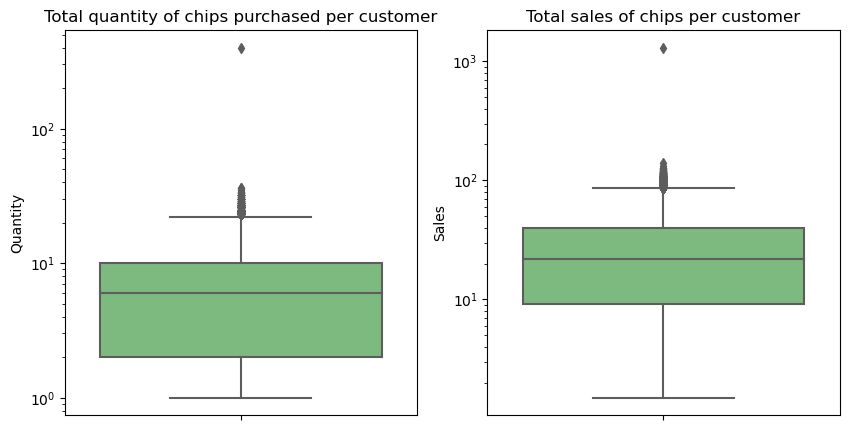

In [20]:
# Group total sales and quantities by customer
grouped_df = df[['LYLTY_CARD_NBR','PROD_QTY','TOT_SALES']]
grouped_df = grouped_df.groupby('LYLTY_CARD_NBR').sum()

# Create a combined plot to display total quantity purchased and sales per customer
fig, axes = plt.subplots(1, 2, figsize = (10,5))

# Create a boxplot for the total quantity purchased per customer
sns.boxplot(ax=axes[0], y="PROD_QTY", data=grouped_df, palette='Greens').set(ylabel='Quantity')
axes[0].set_title('Total quantity of chips purchased per customer')
axes[0].set_yscale('log')

# Create a boxplot of total sales per customer
sns.boxplot(ax=axes[1], y='TOT_SALES', data=grouped_df, palette='Greens').set(ylabel='Sales')
axes[1].set_title('Total sales of chips per customer')
axes[1].set_yscale('log')

It looks like there are a few outliers in the total quantity of chips purchased  and total sales of chips per customer. This is good to keep in mind. For now, we will keep outliers in our dataset, as it is valuable for the supermarket to understand the full range of purchasing behaviour of their customers.

### **Distribution of customer segments**

The dataset has classified customers based on their membership type and lifestage. It would be of interest to understand the distribution of customers into these segments using a bar plot. 

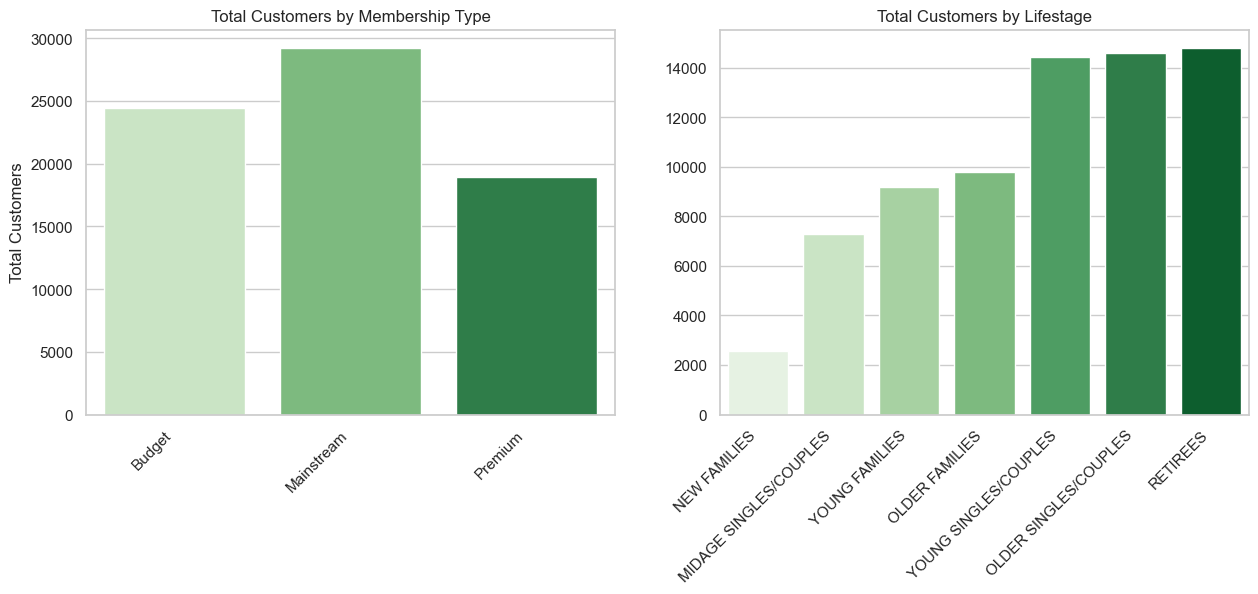

In [21]:
# Count number of customers by membership type
membership_count = df.groupby('PREMIUM_CUSTOMER')['LYLTY_CARD_NBR'].nunique().reset_index()

# Count number of customers by lifestage
lifestage_count = df.groupby('LIFESTAGE')['LYLTY_CARD_NBR'].nunique().reset_index()
lifestage_count.sort_values(by='LYLTY_CARD_NBR', inplace=True)

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Create a combined plot to display the number of customers in each segment
fig, axes = plt.subplots(1,2, figsize=(15,5))

# Plot number of customers by membership
sns.barplot(ax=axes[0], data=membership_count, x='PREMIUM_CUSTOMER', y='LYLTY_CARD_NBR', palette='Greens')
axes[0].set_title('Total Customers by Membership Type')
axes[0].set_xlabel('')
axes[0].set_ylabel('Total Customers')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Plot number of customers by lifestage
sns.barplot(ax=axes[1], data=lifestage_count, x='LIFESTAGE', y='LYLTY_CARD_NBR', palette='Greens')
axes[1].set_title('Total Customers by Lifestage')
axes[1].set_xlabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].get_xaxis().set_visible(True)

From the plots above, it seems that there are more mainstream membership types than budget membership types. Premium memberships make up the smallest number.

Retirees, older singles/couples, and young single/couples are the largest customer segments based on lifestage. Families of all ages and midage singles/couples make up a smaller segment. New families are the smallest lifestage segment.

# **Data Analysis**
Now that the data is clean, and we have a good understanding of the key variables of interest, we will move onto the main goal of this analysis: to identify **an opportunity to boost revenue within a customer segment where chip sales are lacking**.

## **Segmentation**
Having illustrated the distribution of each segment, we sought to understand how each segment differed from each other in chip purchasing behaviour.

### **Purchasing behaviour based on membership type**

First, let's examine whether total chip sales differs by membership type. To do this, we will present the total sales and purchase quantity per customer as box plots. This will help us identify extreme outliers, and examine the distribution of data. 

Then, we will use an ANOVA model to test for any associations between membership type and purchasing behaviour. This test allows us to compare means across the three membership types of premium, mainstream, and budget.

Text(0.5, 0, '')

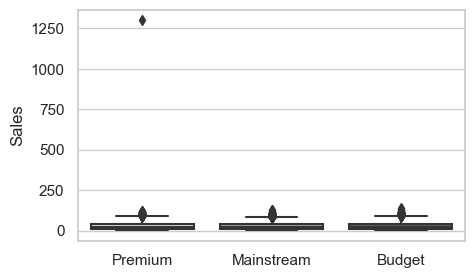

In [22]:
# Calculate the total sales per customer
avg_sales = df.groupby(['LYLTY_CARD_NBR','PREMIUM_CUSTOMER'])['TOT_SALES'].sum().reset_index()

# Plot a boxplot of total sales per customer by membership type
plt.figure(figsize=(5,3))
sns.boxplot(y="TOT_SALES", x='PREMIUM_CUSTOMER', data=avg_sales, palette='Greens')
plt.ylabel('Sales')
plt.xlabel('')

There appears to be one outlier who bought more than 1250 chip packets. Let's remove them for the purposes of this analysis. This will prevent their data from skewing the results of the ANOVA, and overestimating the true difference in sales between groups.

In [23]:
# Identify the index of the outlier
print(np.where(avg_sales['TOT_SALES']>1200))

(array([59694]),)


Text(0.5, 1.0, 'Total sales per customer by membership type')

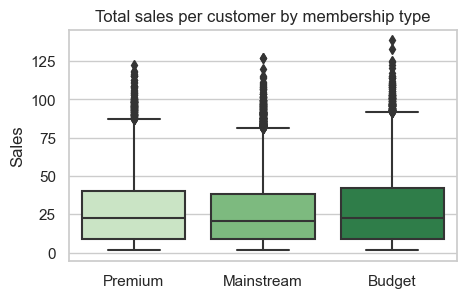

In [24]:
# Remove index 59694
avg_sales_2 = avg_sales.drop(59694)

# Plot an updated boxplot without the outlier
plt.figure(figsize=(5,3))
sns.boxplot(y="TOT_SALES", x='PREMIUM_CUSTOMER', data=avg_sales_2, palette='Greens')
plt.ylabel('Sales')
plt.xlabel('')
plt.title('Total sales per customer by membership type')

In [25]:
# Fit an ANOVA model to test for the association between membership type and total sales per customer
sales_mod = ols('TOT_SALES ~ PREMIUM_CUSTOMER', data = avg_sales_2).fit()
sales_table = sm.stats.anova_lm(sales_mod, typ=2)

# Calculate Eta-squared as the effect size
# Eta-squared = SS_between / SS_total
ss_between = sales_table['sum_sq']['PREMIUM_CUSTOMER']
ss_total = sales_table['sum_sq']['Residual'] + ss_between
eta_squared = ss_between / ss_total

# Add Eta-squared to the ANOVA table
sales_table['Eta-squared'] = eta_squared

# Print the ANOVA table with effect size
print(sales_table)

                        sum_sq       df          F        PR(>F)  Eta-squared
PREMIUM_CUSTOMER  5.184184e+04      2.0  63.189106  3.812124e-28     0.001737
Residual          2.979492e+07  72633.0        NaN           NaN     0.001737


At first glance, the significant p-value suggests a significant association between membership type and total sales per customer. However, upon further inspection of the effect size of 0.002, we realize that the effect size of membership type on total sales is very small. The significant association may have likely been a result of the large sample size. Visual inspection of the box plot above also suggests there may not be a practical difference between total sales per customer based on membership type.

Let's see if we get a similar finding with total quantity purchased per customer.

Text(0.5, 0, '')

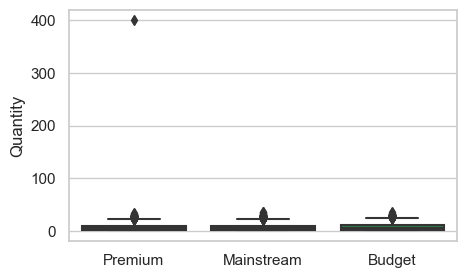

In [26]:
# Calculate the total quantity purchased per customer
avg_qty = df.groupby(['LYLTY_CARD_NBR','PREMIUM_CUSTOMER'])['PROD_QTY'].sum().reset_index()

# Plot a boxplot of total sales per customer by membership type
plt.figure(figsize=(5,3))
sns.boxplot(y="PROD_QTY", x='PREMIUM_CUSTOMER', data=avg_qty, palette='Greens')
plt.ylabel('Quantity')
plt.xlabel('')

Again, there seems to be one outlier in the premium membership type segment who purchased more than 350 chip packets. Let's identify and remove them for this analysis.

In [27]:
# Identify the index of the outlier
print(np.where(avg_qty['PROD_QTY']>350))

(array([59694]),)


Text(0.5, 1.0, 'Quantity purchased per customer by membership type')

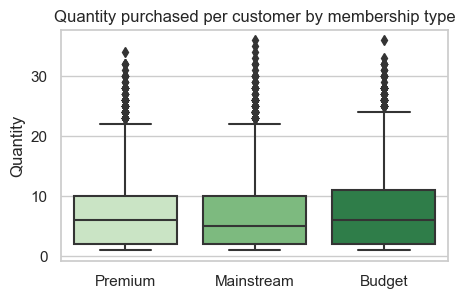

In [28]:
# Remove index 59694
avg_qty_2 = avg_qty.drop(59694)

# Plot an updated boxplot without the outlier
plt.figure(figsize=(5,3))
sns.boxplot(y="PROD_QTY", x='PREMIUM_CUSTOMER', data=avg_qty_2, palette='Greens')
plt.ylabel('Quantity')
plt.xlabel('')
plt.title('Quantity purchased per customer by membership type')

In [29]:
# Fit an ANOVA model to test for the association between membership type and total sales per customer
qty_mod = ols('PROD_QTY ~ PREMIUM_CUSTOMER', data = avg_qty_2).fit()
qty_table = sm.stats.anova_lm(qty_mod, typ=2)

# Calculate Eta-squared as the effect size
# Eta-squared = SS_between / SS_total
ss_between = qty_table['sum_sq']['PREMIUM_CUSTOMER']
ss_total = qty_table['sum_sq']['Residual'] + ss_between
eta_squared = ss_between / ss_total

# Add Eta-squared to the ANOVA table
qty_table['Eta-squared'] = eta_squared

# Print the ANOVA table with effect size
print(qty_table)

                        sum_sq       df          F        PR(>F)  Eta-squared
PREMIUM_CUSTOMER  5.553416e+03      2.0  95.554654  3.594516e-42     0.002624
Residual          2.110631e+06  72633.0        NaN           NaN     0.002624


Similar to the ANOVA results of sales per customer by membership type, a significant p-value was derived, but very small effect sizes are observed. A similar conclusion can be made with the boxplot suggesting that there may not be a practical difference in total quantity per customer between membership types.

What this implies is that even though the average customer with a premium membership may spend more on their membership and spend more at the supermarket overall (Boudet, Huang &  von Difloe, 2020), they are not buying more chips, or spending more chips, than the average customer with a budget or mainstream membership.

### **Purchasing behaviour based on lifestage**
To narrow our target group even futher, let's dive deeper into the average spending per customer among different lifestage segments within the premium membership group. A bar plot will help visualize the relative constributions of the average premium member by lifestage. 

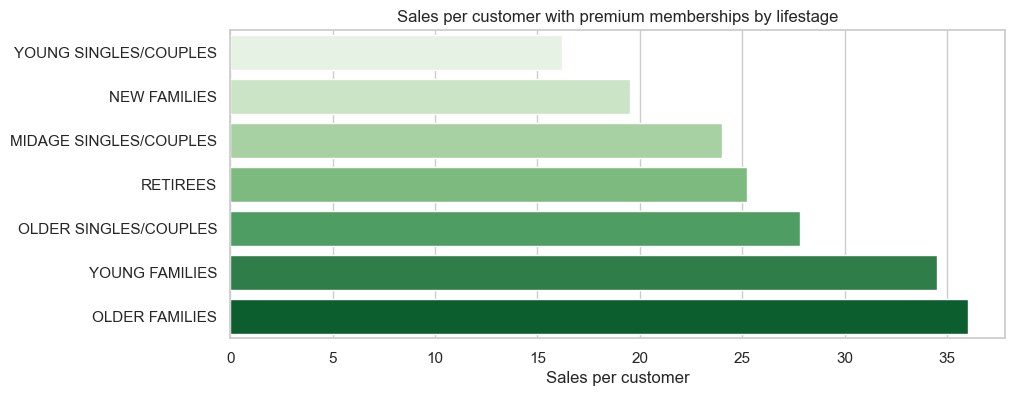

In [30]:
# Subset the dataframe to include only customers with premium memberships
df_premium = df[df['PREMIUM_CUSTOMER'] == 'Premium']

# Store the total sales per premium customer by lifestage in a new dataframe
df1 = df_premium.groupby(['LYLTY_CARD_NBR','LIFESTAGE'])['TOT_SALES'].sum().reset_index()
df2 = df1.groupby('LIFESTAGE')['TOT_SALES'].mean().reset_index()
df2.sort_values(by='TOT_SALES', inplace=True)

# Create a horizontal bar plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 4))
ax = sns.barplot(x='TOT_SALES', y='LIFESTAGE', data=df2, palette='Greens')
ax.set(xlabel='Sales per customer', ylabel='',
       title='Sales per customer with premium memberships by lifestage')

# Show the plot
plt.show()

From the barplot above, it is apparent that young singles/couples and new families with premium memberships contribute the least in chip sales per customer within the premium membership customer segment.

This makes sense, as this demographic may not have children old enough to consume as many chips as older families. 20-30 year old customers may also be more health conscious. 

## **Problem Identification**

Based on our analysis of the segments, it has been observed that premium customers contribute the least to the revenue in the chips category. This presents a significant opportunity, as premium customers are generally characterized by their higher spending potential in other categories. Furthermore, premium members are already loyal to the supermarket, and a tailored marketing strategy could possibly create a pool of repeat chip buyers who can become advocates of the company. The goal, therefore, is to enhance the sales of chips among this particular segment.

Our analysis revealed that young singles/couples and new families contribute the least within the premium members segment. The next step in our analysis is to look closely at this group's favorite chip flavors, brands, and pack sizes. Our goal is to tap into their willingness to spend more, just as they do in other product categories. By focusing on what these valuable customers prefer, we plan to design a marketing strategy specific to our target group and nurture their continued loyalty.

## **Targeting**
We have successfully identified the customer segment for the supermarket to target for marketing. These customers have premium memberships and are young singles or couples, and new families.

Let's subset the full dataframe to only include young single/couples and new families with premium memberships. 

In [28]:
# Create a new dataframe for the target customer group
target_df = df[(df.PREMIUM_CUSTOMER == 'Premium')]
target_df = target_df[(df.LIFESTAGE == 'YOUNG SINGLES/COUPLES')|
                      (df.LIFESTAGE == 'NEW FAMILIES')]

# Look at the first five rows of target_df
target_df.head()

/var/folders/1d/v9plw3yn5d76qsgycn4621240000gn/T/ipykernel_6123/3802100862.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  target_df = target_df[(df.LIFESTAGE == 'YOUNG SINGLES/COUPLES')|


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE_GRAMS,BRAND,FLAVOURS
0,1000,YOUNG SINGLES/COUPLES,Premium,2018-10-17,1,1,5,2,6.0,175,Natural,seasalt
8,1009,NEW FAMILIES,Premium,2018-11-20,1,9,20,1,5.7,330,Doritos,Cheese
30,1024,YOUNG SINGLES/COUPLES,Premium,2019-02-20,1,31,5,1,3.0,175,Natural,seasalt
41,1042,YOUNG SINGLES/COUPLES,Premium,2018-07-21,1,45,94,1,2.3,220,Burger,Cheese
42,1042,YOUNG SINGLES/COUPLES,Premium,2019-02-12,1,46,63,1,4.2,135,Kettle,seasalt


### **Identifying the target chip flavours and brands to market to target group**

In order to effectively target our target group, the supermarket should first understand how the different chip flavours and brands are perceived by our target group. We will create perceptual charts to illustrate how the top 15 flavours and brands based on purchase frequency compare with each other in terms of our target's groups perceptions. Specifically, our map will display chip flavours and brands by perceived uniqueness and popularity. 

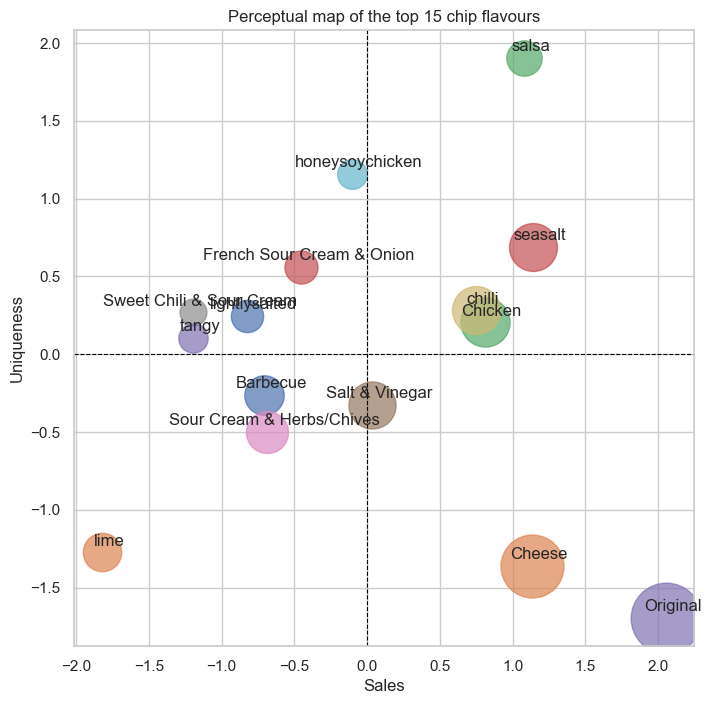

In [32]:
np. random.seed(123)
# Get the top 15 flavors based on purchase count
top_flavors = target_df.groupby('FLAVOURS').size().nlargest(15).index

# Filter the original dataframe to include only the top 15 flavors
df_top_flavors = target_df[target_df['FLAVOURS'].isin(top_flavors)]

# Group the data by 'FLAVOURS' to get the sum of 'TOT_SALES' and the average of 'PROD_QTY'
flavor_sales_qty = df_top_flavors.groupby('FLAVOURS').agg({
    'TOT_SALES': 'sum',     # Total sales for each flavor
    'PROD_QTY': 'mean',     # Average product quantity for each flavor
}).reset_index()

# Convert flavors to dummy variables
flavours_df = pd.get_dummies(flavor_sales_qty['FLAVOURS'], prefix='FLAVOUR')

# Standardize the data
scaler = StandardScaler()
flavours_standardized = scaler.fit_transform(flavor_sales_qty[['TOT_SALES', 'PROD_QTY']])

# Apply PCA
pca = PCA(n_components=2)
flavours_pca = pca.fit_transform(flavours_standardized)

# Create a new DataFrame with PCA results
pca_df = pd.DataFrame(flavours_pca, columns=['PC1', 'PC2'])
pca_df['FLAVOURS'] = flavor_sales_qty['FLAVOURS']

# Plot the perceptual map
plt.figure(figsize=(8, 8))

# Scatter plot with marker size based on total revenue
for flavour in pca_df['FLAVOURS'].unique():
    subset = pca_df[pca_df['FLAVOURS'] == flavour]
    total_sales = flavor_sales_qty[flavor_sales_qty['FLAVOURS'] == flavour]['TOT_SALES'].iloc[0]
    size = total_sales * 0.4 # Adjust the size scaling factor as needed
    plt.scatter(subset['PC1'], subset['PC2'], label=flavour, s=size, alpha=0.7)

# Add labels and title
plt.title('Perceptual map of the top 15 chip flavours')
plt.xlabel('Sales')
plt.ylabel('Uniqueness')

# Annotate each point with its flavor
for i, flavour in enumerate(pca_df['FLAVOURS']):
    plt.annotate(flavour, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), textcoords="offset points", xytext=(5,5), ha='center')

# Show x and y axes at 0
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

# Show the plot
plt.show()

This map reveals that salsa, sea salt, and chilli are, not only the most unique, but also among the highest sellers. Flavours such as original and cheese may be the best sellers, but are clearly not as unique. 

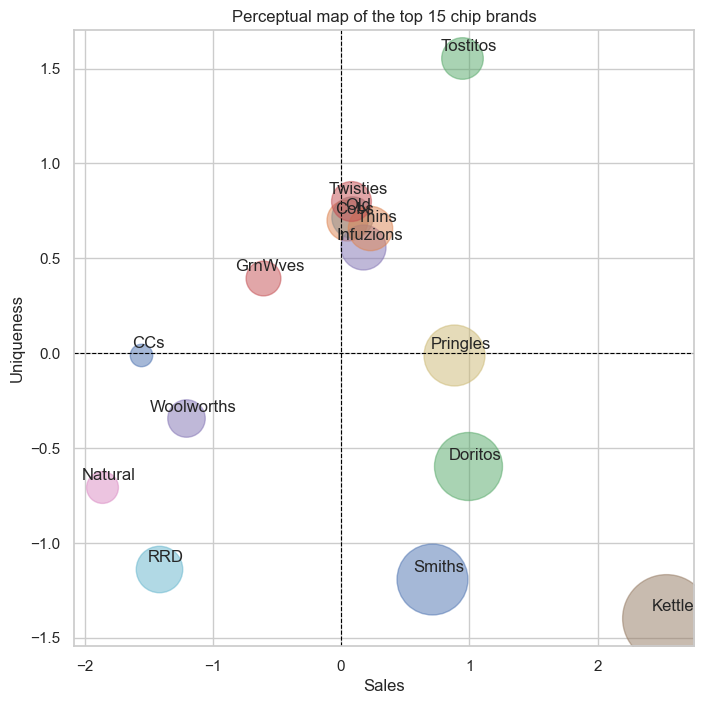

In [33]:
# Get the top 15 flavors based on purchase count
top_brands = target_df.groupby('BRAND').size().nlargest(15).index

# Filter the original dataframe to include only the top 15 flavors
df_top_brands = target_df[target_df['BRAND'].isin(top_brands)]

# Group the data by 'FLAVOURS' to get the sum of 'TOT_SALES' and the average of 'PROD_QTY'
brands_sales_qty = df_top_brands.groupby('BRAND').agg({
    'TOT_SALES': 'sum',     # Total sales for each flavor
    'PROD_QTY': 'mean',     # Average product quantity for each flavor
}).reset_index()

# Convert flavors to dummy variables
brands_df = pd.get_dummies(brands_sales_qty['BRAND'], prefix='BRAND')

# Standardize the data
scaler = StandardScaler()
brands_standardized = scaler.fit_transform(brands_sales_qty[['TOT_SALES', 'PROD_QTY']])

# Apply PCA
pca = PCA(n_components=2)
brands_pca = pca.fit_transform(brands_standardized)

# Create a new DataFrame with PCA results
pca_df = pd.DataFrame(brands_pca, columns=['PC1', 'PC2'])
pca_df['BRAND'] = brands_sales_qty['BRAND']

# Plot the perceptual map
plt.figure(figsize=(8,8))

# Scatter plot with marker size based on total revenue
for brand in pca_df['BRAND'].unique():
    subset = pca_df[pca_df['BRAND'] == brand]
    total_sales = brands_sales_qty[brands_sales_qty['BRAND'] == brand]['TOT_SALES'].iloc[0]
    size = total_sales * 0.4
    plt.scatter(subset['PC1'], subset['PC2'], label=brand, s=size, alpha=0.5)

# Add labels and title
plt.title('Perceptual map of the top 15 chip brands')
plt.xlabel('Sales')
plt.ylabel('Uniqueness')

# Annotate each point with its flavor
for i, brand in enumerate(pca_df['BRAND']):
    plt.annotate(brand, (pca_df['PC1'].iloc[i], pca_df['PC2'].iloc[i]), textcoords="offset points", xytext=(5,5), ha='center')

# Show x and y axes at 0
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.axvline(0, color='black', linestyle='--', linewidth=0.8)

# Show the plot
plt.show()

The map above reveals that Tosititos, Pringles, and Infuzions stand out as the most unique and popular brands. These insights into the flavours and brands our target segment perceives as most unique and preferred will guide our marketing recommendations.

### **Identifying the preferred pack size within the target customer group**

The last chip product characteristic the supermarket can consider in their marketing strategy is pack size. We can count the most popular pack sizes purchased by our target group using a bar plot. 

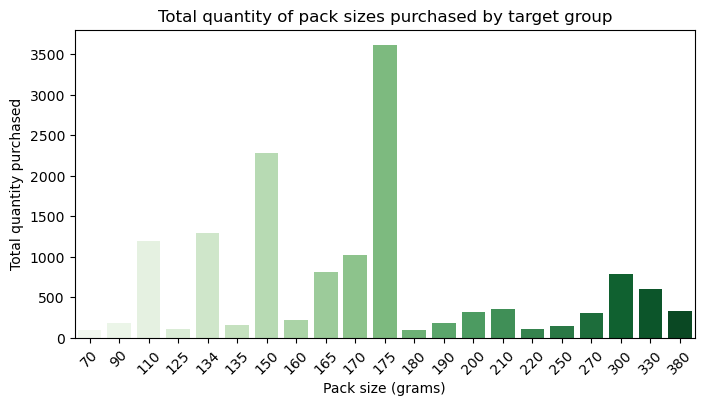

In [32]:
# Group the target dataframe by pack size and display the sum of packs bought
pack_df = target_df.groupby('PACK_SIZE_GRAMS')['PROD_QTY'].sum().reset_index()
pack_df = pack_df.apply(pd.to_numeric)
pack_df.sort_values(by='PACK_SIZE_GRAMS', inplace=True)

# Create a bar plot to visualize the above grouped dataframe
plt.figure(figsize=(8, 4))
sns.barplot(x='PACK_SIZE_GRAMS', y='PROD_QTY', data=pack_df, palette='Greens')
plt.xlabel('Pack size (grams)')
plt.ylabel('Total quantity purchased')
plt.title('Total quantity of pack sizes purchased by target group')
plt.xticks(rotation=45)
plt.show()

It is apparent that the most popular pack sizes are 175g, followed by 150g and 134g. These sizes are at the middle of the range of pack sizes.

## **Positioning**
We have identified a customer segment that contributes the least to chip revenues, and the chip characteristics that should be used to tailor our marketing strategy for this group.

By doing so, we will be able to **position ourselves** as the best supermarket for young singles/couples and new families with premium memberships to buy their most preferred, and the most unique chips.

# **Marketing Recommendations**

Our recommendations will be tailored to our target customer group: young singles/couples and new families with premium memberships. As premium members of the supermarket, these customers are already loyal to the company, and the goal of our marketing strategy is to turn them into repeat customers of chips. We will describe how the strategy can cover the four P's of marketing: Product, Place, Price, and Promotion.

## **1. Product**

### **Prioritizing salsa-flavoured chips, the Tostito brand, and the 175-gram pack size**

Our target segment has a strong affinity for salsa-flavored chips,  the Tostito brand, and the 175-gram pack size. Based on this insight, we strongly advocate for expanding the supermarket's chip inventory to include more options that align with these preferred characteristics.

**Implementation**

<u>Expansion of choices:</u> Our proposed expansion involves introducing an greater array of salsa-flavored and Tostito brand chips in the desired 175-gram pack size.

<u>New textures and dips:</u> Moreover, we recommend expanding offerings by incorporating various textures of salsa-flavoured chips and an assortment of salsa-flavored dips. This strategic move is aimed at accommodating the nuanced preferences among the target segment. 

**Benefits**

<u>Appealing to more tastes:</u> In providing this expanded range of the unique preferences of the target segment, the supermarket can appeal to more new families and young singles/couples with premium memberships. With more customers finding their chip tastes satisfied by the supermarket's offerings, the supermarket will be able to capture the sales of a greater proportion of this group. 

<u>Loyalty-building:</u> By ensuring that the target segment is able to find their favourite chip products within the store, the supermarket can ensure that customers feel a sense of reassurance that they can depend on the store for their unique chip needs. This will nurture the existing relationship between the company and these loyal customers, promoting long-term sales. 

## **2. Place**
### **Intentional placement of target chips**

**Implementation**

<u>Point-of-sale placement:</u> To boost sales within our target segment, we recommend placing salsa-flavoured and Tostito brand chips in 175-gram pack sizes at the point-of-sale. 

<u>Eye-level placement:</u> Additionally, the supermarket should employ eye-level placement for these chips to maximize the chance of our target customers spotting their unique and preferred chips.

**Benefits**

<u>Enhancing sales:</u> Point-of-sale placements will ensure the chips grab the attention of our target customers as they are considering their final purchases, and encourage them to pick a chip pack up as they prepare to check out (Harrison, n.d.). Eye-level placement will also make these products as accessible as possible for customers, tailoring the shopping space for their loyal customers. 

## **3. Price**

### **Special deals, prices, and points offers**

**Implementation**

<u>Special deals:</u> Special deals such as 'Buy 2 or more for 3.49 each and save 0.51 each' are a common way of capturing the attention of customers to buy more than they would otherwise. 

<u>Exclusive prices:</u> The supermarket can also consider offering premium customers an exclusive price for specific chips (i.e., salsa-flavoured and Tostito brand chips).

<u>Loyalty points system:</u> Finally, the supermarket can implement a loyalty points system where premium members can earn points for purchasing salsa-flavoured and Tostito brand chips in 175-gram packs.

**Benefits**

<u>Perception of savings:</u> While the monetary value of deals, special prices, and point offers are not significant to the customer or supermarket, they provide customers with a sense of urgency to not miss out on a deal, triggering their impulse to purchase (Thorpe, 2023). 

<u>Loyalty-building:</u> By providing special deals, prices, and point offers for chips our target group perceives as most unique and preferred, the supermarket can help build a strong connection with their premium customers, letting them know that their loyalty to the company is valued. This will not only encourage short-term sales, but will also nurture the premium membership segment, promoting a long-lasting relationship and long-term sales. 

## **4. Promotion**
### **Gold-coloured labels for premium members**
We also propose the implementation of distinctive gold-colored labels on the supermarket shelves. These labels will signify the aforementioned special premium member pricing for chip products, creating a visually appealing and exclusive shopping experience for our targeted audience.

**Implementation**

<u>Visual distinction:</u> Gold-colored labels can be strategically placed on the aisles featuring chip products. This visual distinction will immediately catch the attention of premium members, guiding them to a dedicated section with exclusive pricing.

<u>Informative signage:</u> Complementing the gold labels, informative signage should communicate the exclusive benefits of premium membership, reinforcing the idea that these products are tailored specifically for them.

**Benefits**

<u>Enhanced visibility:</u> The gold-colored labels create a standout visual appeal, attracting the attention of Premium members and reinforcing a sense of exclusivity.

<u>Incentivized purchases:</u> Premium member pricing serves as a strong incentive for our target audience to choose chip products from the labeled section, potentially increasing both sales and quantity purchased.

<u>Loyalty building:</u> The strategy not only drives immediate sales but also contributes to long-term loyalty by associating the premium membership with special privileges and savings.

### **"My Offers" tab on mobile App for targeted deals**

To further engage and cater to the preferences of our target segment, we recommend leveraging the "My Offers" tab on the supermarket's mobile application. This personalized approach will provide targeted deals and offers on chip products, creating a seamless and convenient shopping experience for our identified audience.

**Implementation**

<u>Personalized notifications:</u> Premium members will receive personalized notifications through the mobile app's "My Offers" tab, alerting them to exclusive deals on chip products tailored to their preferences and purchase history.

<u>Unlockable offers:</u> Users can unlock special offers by engaging with the app, such as making repeat purchases, participating in surveys, or referring friends. This gamified approach encourages continued app interaction and loyalty.

<u>Limited-time promotions:</u> To instill a sense of urgency, time-sensitive promotions will be featured, prompting premium members to take advantage of the exclusive deals on chip products within a specified timeframe.

**Benefits**

<u>Personalized shopping experience:</u> The "My Offers" tab provides a personalized space for premium members, enhancing their overall shopping experience by tailoring promotions to their specific chip preferences.

<u>Increased app engagement:</u> The strategy promotes sustained engagement with the mobile app, fostering a deeper connection with the brand and potentially influencing future purchasing decisions.

<u>Urgency and exclusivity:</u> Limited-time promotions create a sense of urgency and exclusivity (Thorpe, 2023), encouraging premium members to actively participate in unlocking and redeeming special offers.

# **References**

Boudet, J., Huang, J., & von Difloe, R. (2020, October 22). Coping with the big switch: How paid loyalty programs can help bring consumers back to your brand. McKinsey & Company. https://www.mckinsey.com/capabilities/growth-marketing-and-sales/our-insights/coping-with-the-big-switch-how-paid-loyalty-programs-can-help-bring-consumers-back-to-your-brand#

Harrison, S. (n.d.). What is point-of-purchase placement in merchandising? CHRON. https://smallbusiness.chron.com/pointofpurchase-placement-merchandising-25685.html

Thorpe, A. (2023, July 13). Consumer behavior and decision-making in retail. RetailWire. https://retailwire.com/discussion/the-psychology-of-discounts-understanding-consumer-behavior-and-decision-making-in-retail/#:~:text=Perception%20of%20Value&text=The%20larger%20the%20discount%2C%20the,a%20product%20at%20average%20cost.